# Image Replacement and Panoramic Stitching using Homography

In [1]:
import os
print(os.getcwd())

/content


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Function to select points and display/store them
def select_points(im, title, num_points, filename=None):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title(title)
    print(f"Select four corners for {title} (click on the image)")
    pts = plt.ginput(num_points)  # Dynamically select the number of points
    plt.close()
    pts_array = np.array(pts)

    # Display the selected points
    print(f"Selected points for {title}:")
    print(pts_array)

    # Optionally save the points to a CSV file for future use
    if filename:
        df = pd.DataFrame(pts_array, columns=["x", "y"])
        df.to_csv(filename, index=False)
        print(f"Points saved to {filename}")

    return pts_array

In [4]:
# After selecting, you can load the points back from the CSV file for future use
def load_points_from_csv(filename):
    df = pd.read_csv(filename)
    return df.values

In [5]:
# Compute the homography matrix with any number of points
def compute_homography(pts_src, pts_dst):
    A = []
    for i in range(len(pts_src)):  # Adjust for any number of points, not just 4
        x, y = pts_src[i][0], pts_src[i][1]
        x_prime, y_prime = pts_dst[i][0], pts_dst[i][1]

        A.append([-x, -y, -1, 0, 0, 0, x_prime * x, x_prime * y, x_prime])
        A.append([0, 0, 0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])

    A = np.array(A)

    # Perform SVD to solve Ah = 0 in a least squares sense
    U, S, Vh = np.linalg.svd(A)
    h = Vh[-1, :]  # Solution is the last row of Vh

    # Reshape h into a 3x3 matrix
    H = h.reshape((3, 3))
    return H

In [14]:
#   Warps the source image (im_src) onto the destination image (im_dst) using the
#   provided homography matrix H and blends the images.
def warp_and_blend_images(im_src, im_dst, H):

    # Step 1: Create a mask for the warped image
    mask = np.ones(im_src.shape[:2], dtype=np.uint8) * 255
    warped_mask = cv2.warpPerspective(mask, H, (im_dst.shape[1], im_dst.shape[0]))

    # Step 2: Warp the source image onto the destination using the homography matrix
    im_warped = cv2.warpPerspective(im_src, H, (im_dst.shape[1], im_dst.shape[0]))

    # Step 3: Blending the warped image into the destination
    mask_inv = cv2.bitwise_not(warped_mask)  # Invert the mask
    im_dst_bg = cv2.bitwise_and(im_dst, im_dst, mask=mask_inv)  # Background of destination
    im_src_fg = cv2.bitwise_and(im_warped, im_warped, mask=warped_mask)  # Foreground from source

    # Final blended output
    im_out = cv2.add(im_dst_bg, im_src_fg)

    return im_warped, im_out

In [15]:
#  Displays the original images (destination and source), the warped image, and the final blended image.
def display_results(im_dst, im_new_src, im_warped, im_out):

    # Step 1: Display the first two images (Image 1 and Image 2)
    plt.figure(figsize=(15, 5))  # Adjust the size for the first two images

    # Image 1 (Destination)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB))
    plt.title("Image 1 (Destination)")

    # Image 2 (Source)
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(im_new_src, cv2.COLOR_BGR2RGB))
    plt.title("New Image (Source)")

    plt.show()

    # Step 2: Display the warped and final blended images
    plt.figure(figsize=(15, 5))  # Adjust the size for the next two images

    # Warped Image 2
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(im_warped, cv2.COLOR_BGR2RGB))
    plt.title("Warped New Image")

    # Final Blended Result
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB))
    plt.title("Final Blended Image")

    plt.tight_layout()
    plt.show()

## Part-1: Calculate Homography Matrix and replace an image using 4 corner points.

In [16]:
# Load the two images
im_src = cv2.imread('/content/Image2.jpg')  # Image to be mapped (image2)
im_dst = cv2.imread('/content/Image1.jpg')  # Destination image (image1)

print("New image shape:", im_src.shape if im_src is not None else "Failed to load")
print("Destination image shape:", im_dst.shape if im_dst is not None else "Failed to load")

New image shape: (446, 450, 3)
Destination image shape: (1512, 2016, 3)


In [17]:
# Jupyter Notebook / Google Colab doesn't work well with Graphical User Interface (GUI) functions like ginput,
# so this code needs to be executed on Linux/Mac Terminal, or using any IDE on Windows.
# Uncomment these 2 lines to select points from the 2 images and store them in a csv file for homography calculations

# # selecting 4 points
# pts_dst = select_points(im_dst, "Select four corners in image1 (picture on the wall)", 4, "/content/pts_dst.csv")
# pts_src = select_points(im_src, "Select four corners in image2", 4, "/content/pts_src.csv")

In [18]:
# Load points later
pts_dst_loaded = load_points_from_csv("/content/pts_dst.csv")
pts_src_loaded = load_points_from_csv("/content/pts_src.csv")

# Print the loaded points
print("Loaded pts_dst from file:", pts_dst_loaded)
print("Loaded pts_src from file:", pts_src_loaded)

Loaded pts_dst from file: [[ 523.61161116  502.65751575]
 [ 923.25157516  457.2929793 ]
 [ 558.17506751 1077.2749775 ]
 [ 955.65481548 1142.08145815]]
Loaded pts_src from file: [[  2.75211093   2.63505636]
 [446.88509565   3.27226294]
 [  2.75211093 441.03318189]
 [445.6106825  441.03318189]]


In [19]:
# Compute homography
H = compute_homography(pts_src_loaded, pts_dst_loaded)
print("Computed Homography matrix:\n", H)

Computed Homography matrix:
 [[-7.73643388e-04 -1.36888996e-04 -7.22136588e-01]
 [ 3.77532278e-04 -1.86752585e-03 -6.91746039e-01]
 [ 5.10682389e-07 -4.97725579e-08 -1.38517495e-03]]


In [21]:
# Call the warping and blending function
im_warped, im_out = warp_and_blend_images(im_src, im_dst, H)
cv2.imwrite('4_point_image_replace.jpg', im_out)

True

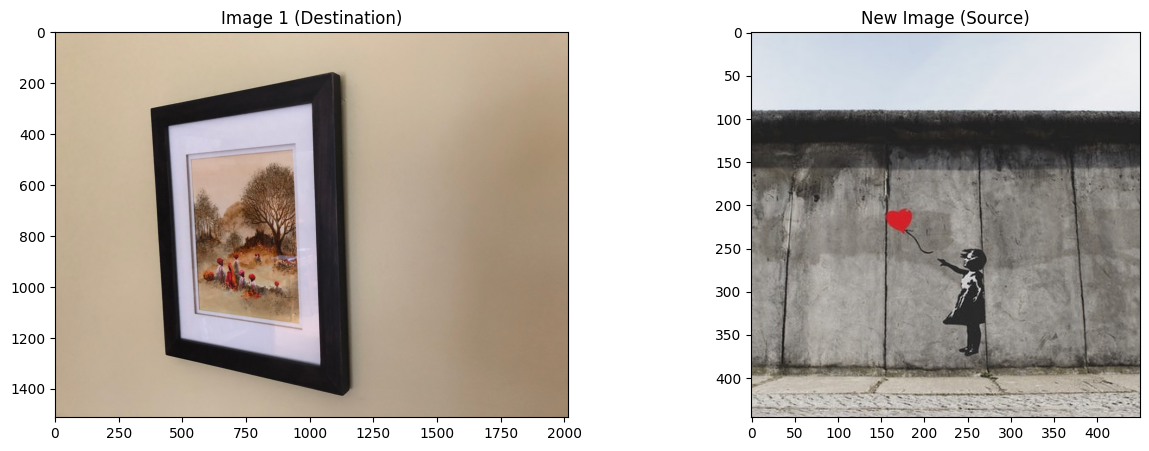

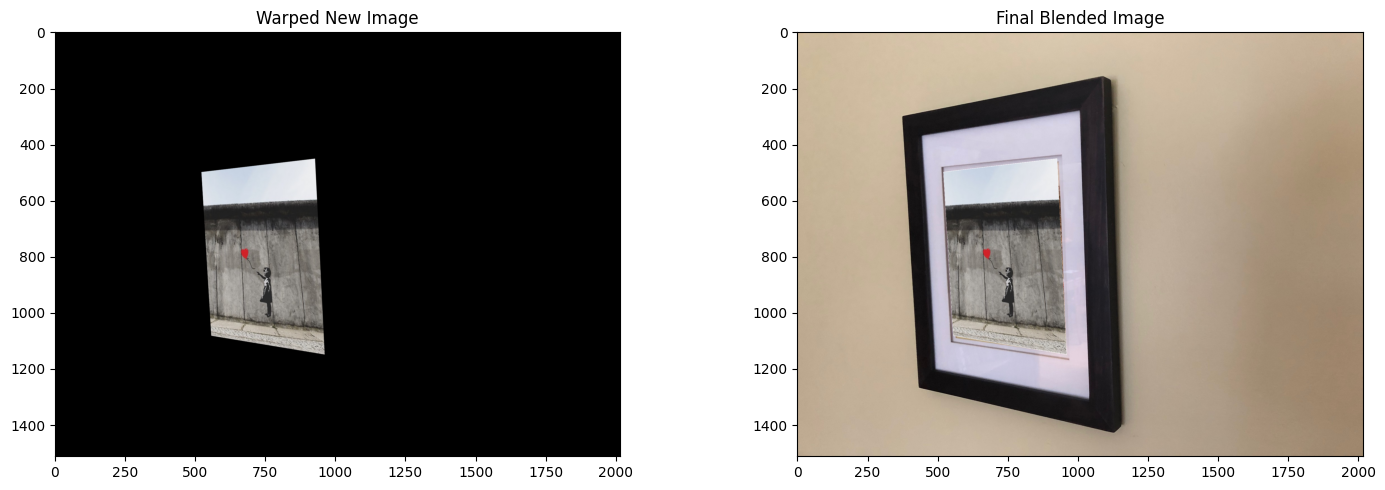

In [22]:
# Display results
# Call the Display Function
display_results(im_dst, im_src, im_warped, im_out)

This code performs image replacement using homography transformations. It allows users to select points in both source and destination images, computes the homography matrix, and uses this matrix to warp and blend the source image onto the destination. The key function compute_homography() forms a system of linear equations from point correspondences and solves it using Singular Value Decomposition (SVD) to find the homography matrix 𝐻. The process involves warping the source image to align with the destination image and blending them seamlessly.

Solving the system using Singular Value Decomposition (SVD):

For 4 point correspondences, the system has 8 equations (4 points give 2 equations each). The matrix A is of the order 8 x 9.

For 4 corner point pairs, SVD solves the equation
𝐴
ℎ
=
0
where
ℎ
is the vectorized form of the homography matrix.
The solution to this system is the right singular vector of
𝐴
corresponding to the smallest singular value, which is computed using SVD.

Since homographies are only determined up to a scale, you can normalize
𝐻
by dividing all of its elements by
ℎ
33
​
   
   (or any other non-zero element) so that
ℎ
33
=
1

## Part-2: Calculate Homography Matrix and replace an image using 8 points.

In [23]:
# Load images
im_new_src = cv2.imread('/content/NewImage.jpg')  # The new image to be mapped
im_dst = cv2.imread('/content/Image1.jpg')  # Destination image (image1)

print("New image shape:", im_new_src.shape if im_new_src is not None else "Failed to load")
print("Destination image shape:", im_dst.shape if im_dst is not None else "Failed to load")

New image shape: (500, 1024, 3)
Destination image shape: (1512, 2016, 3)


In [24]:
# # Uncomment the lines below if you want to manually select 8 points from the images
# pts_dst = select_points(im_dst, "Select eight corners in image1 (picture on the wall)", 8, "/content/pts_dst_8.csv")
# pts_src = select_points(im_new_src, "Select eight corners in NewImage", 8, "/content/pts_src_8.csv")

In [25]:
# Load 8 points from CSV files
pts_dst_loaded = load_points_from_csv("/content/pts_dst_8.csv")
pts_src_loaded = load_points_from_csv("/content/pts_src_8.csv")

# Print the loaded points
print("Loaded pts_dst from file:", pts_dst_loaded)
print("Loaded pts_src from file:", pts_src_loaded)

Loaded pts_dst from file: [[ 536.57290729  511.29837984]
 [ 931.89243924  463.77362736]
 [ 562.49549955 1090.23627363]
 [ 955.65481548 1135.60081008]
 [ 521.45139514  481.05535554]
 [ 934.05265527  429.21017102]
 [ 540.89333933 1094.55670567]
 [ 962.13546355 1161.52340234]]
Loaded pts_src from file: [[5.73513780e+00 6.58642293e+00]
 [1.01655051e+03 7.30078008e+00]
 [7.16385210e+00 4.90206213e+02]
 [1.01797922e+03 4.88063142e+02]
 [7.34637749e-01 1.57208578e-01]
 [1.02297972e+03 8.71565728e-01]
 [2.87770920e+00 4.97349785e+02]]


In [26]:
# Compute homography using the loaded points
H = compute_homography(pts_src_loaded, pts_dst_loaded)
print("Computed Homography matrix:\n", H)

Computed Homography matrix:
 [[ 3.60641887e-04  6.57770980e-05  7.31241574e-01]
 [-1.60122643e-04  1.69002513e-03  6.82114967e-01]
 [-2.02229557e-07  8.78713425e-09  1.38443157e-03]]


In [28]:
# Call the warping and blending function
im_warped, im_out = warp_and_blend_images(im_new_src, im_dst, H)
cv2.imwrite('8_point_image_replace.jpg', im_out)

True

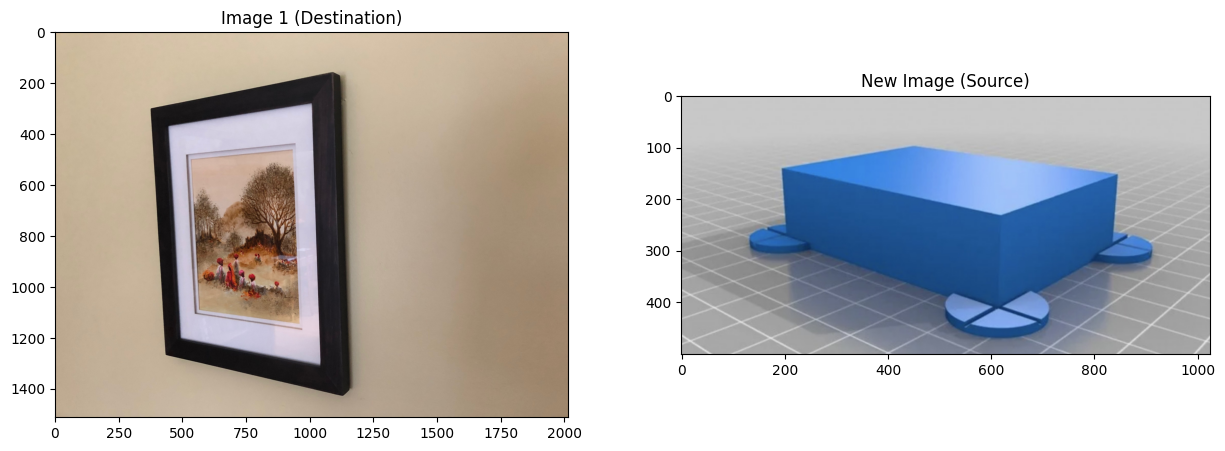

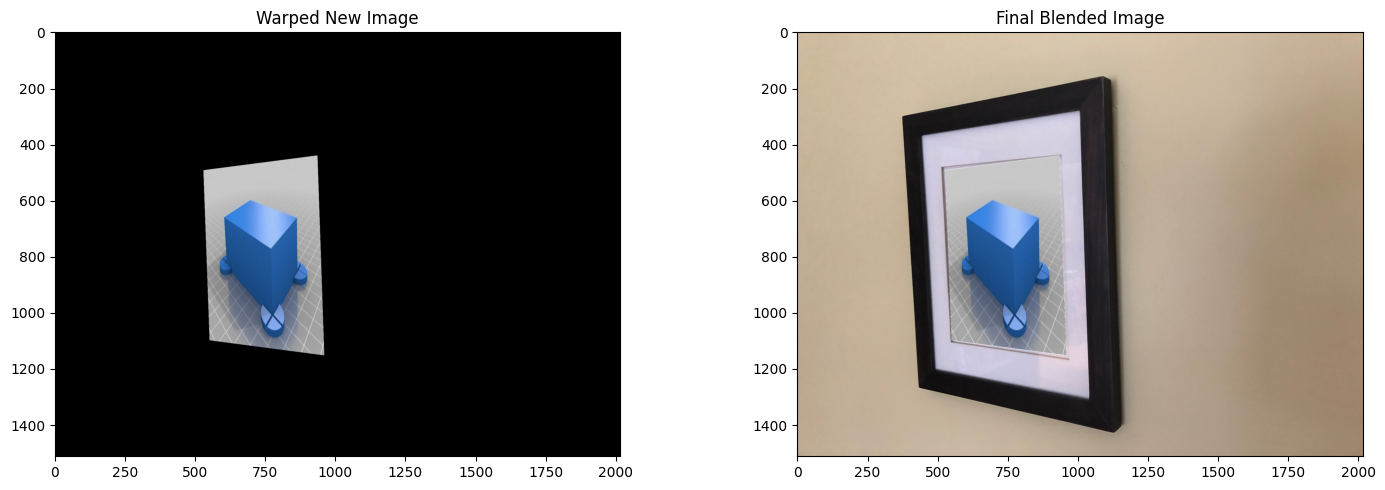

In [29]:
# Display results
# Call the Display Function
display_results(im_dst, im_new_src, im_warped, im_out)

Since there are now 8 point pairs (providing 16 equations), the system is overdetermined, and the solution is found using the least-squares method to minimize the error across all equations.

For 8 point correspondences, the system has 16 equations (8 points give 2 equations each). The matrix
𝐴
is of the order
16
×
9.

For 8 corner point pairs, SVD solves the equation
𝐴
ℎ
=
0
by using the least-squares approximation.

The goal of the least-squares approach is to find the solution that minimizes the sum of the squared errors between the predicted and actual values.

Mathematically, the least-squares problem can be written as:

$$\min_h \| A h \|^2$$

Where:

- A is the matrix of coefficients derived from the point correspondences (size \$2n \times 9 \$ for n point correspondences).
- h is the vector containing the unknowns (the 9 elements of the homography matrix).
- $| A h \|^2$ is the sum of the squared residuals (errors) for all equations.



There is no change in the computation of H matrix in the 4 points and the 8 points case in terms of the compute_homography function. The following SVD function call handles both the cases automatically by using the necessary equations as required:

U, S, Vh = np.linalg.svd(A)


Differeneces in the H-Matrix in both the cases:

The homography matrix computed using 8 points is more robust and accurate compared to the one computed with 4 points. With 8 points, there are more constraints, leading to better error minimization and a more stable transformation. The values in the 8-point matrix are smoother and more consistent, indicating a more precise alignment. The 4-point matrix, while functional, is more prone to error or instability due to fewer correspondences. Thus, the 8-point homography provides a more reliable result, especially in the presence of noise or slight misalignments in point correspondences. However, as we can see from the results, the difference in the final images in 4-points and 8-points case is hardly noticable. The homography calculations are accurate in both the cases resulting in a perfectly blended image.

## Part-3: Create a Panoramic Stitch of 5 images using Homography.


In [6]:
# Function to warp and blend images
def warp_and_blend_images_panorama(im_src, im_dst, H, alpha, beta):
    # Step 1: Get sizes of source and destination images
    h_dst, w_dst = im_dst.shape[:2]
    h_src, w_src = im_src.shape[:2]

    # Step 2: Create a larger canvas to fit both images
    corners_src = np.array([[0, 0], [w_src, 0], [w_src, h_src], [0, h_src]], dtype=np.float32)
    corners_src_warped = cv2.perspectiveTransform(np.array([corners_src]), H)[0]

    [xmin, ymin] = np.int32(np.min(corners_src_warped, axis=0).flatten())
    [xmax, ymax] = np.int32(np.max(corners_src_warped, axis=0).flatten())

    translation_dist = [-xmin if xmin < 0 else 0, -ymin if ymin < 0 else 0]
    panorama_width = max(xmax, w_dst) + translation_dist[0]
    panorama_height = max(ymax, h_dst) + translation_dist[1]

    # Step 3: Warp the source image to the new panorama canvas
    H_translate = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    im_warped = cv2.warpPerspective(im_src, H_translate @ H, (panorama_width, panorama_height))

    # Step 4: Paste the destination image on the same canvas
    im_panorama = np.zeros((panorama_height, panorama_width, 3), dtype=np.uint8)
    im_panorama[translation_dist[1]:h_dst+translation_dist[1], translation_dist[0]:w_dst+translation_dist[0]] = im_dst

    # Step 5: Create masks for blending
    mask_warped = np.zeros((panorama_height, panorama_width), dtype=np.uint8)
    mask_warped[np.any(im_warped > 0, axis=-1)] = 255

    mask_dst = np.zeros((panorama_height, panorama_width), dtype=np.uint8)
    mask_dst[translation_dist[1]:h_dst+translation_dist[1], translation_dist[0]:w_dst+translation_dist[0]] = 255

    # Step 6: Linear blending in overlapping regions
    overlap_mask = cv2.bitwise_and(mask_warped, mask_dst)
    im_warped_overlap = cv2.bitwise_and(im_warped, im_warped, mask=overlap_mask)
    im_panorama_overlap = cv2.bitwise_and(im_panorama, im_panorama, mask=overlap_mask)

    blended_overlap = cv2.addWeighted(im_warped_overlap, alpha, im_panorama_overlap, beta, 0)

    # Step 7: Combine the non-overlapping parts
    non_overlap_warped = cv2.bitwise_and(im_warped, im_warped, mask=cv2.bitwise_not(overlap_mask))
    non_overlap_panorama = cv2.bitwise_and(im_panorama, im_panorama, mask=cv2.bitwise_not(overlap_mask))

    final_panorama = cv2.add(non_overlap_warped, non_overlap_panorama)
    final_panorama = cv2.add(final_panorama, blended_overlap)

    return final_panorama

In [7]:
# Function to create panorama of 2 images
def create_panorama(im_src, filename_src, im_dst, filename_dst, alpha, beta):
    # Load points from CSV files
    pts_src_loaded = load_points_from_csv(f"{filename_src}.csv")
    pts_dst_loaded = load_points_from_csv(f"{filename_dst}.csv")

    # Compute Homography Matrix
    H = compute_homography(pts_src_loaded, pts_dst_loaded)
    # H_normalized = normalize_homography(H)

    # Warp and Blend Images using the improved function
    im_panorama = warp_and_blend_images_panorama(im_src, im_dst, H, alpha, beta)

    return im_panorama

In [8]:
# Load the four images
im_left = cv2.imread('/content/Pan00.jpg')  # Left Image
im_mid_left = cv2.imread('/content/Pan01.jpg')   # Middle-Left Image
im_mid_right = cv2.imread('/content/Pan02.jpg')  # Middle-Right Image
im_right = cv2.imread('/content/Pan03.jpg')      # Right Image
im_last = cv2.imread('/content/Pan04.jpg')      # Far Right Image


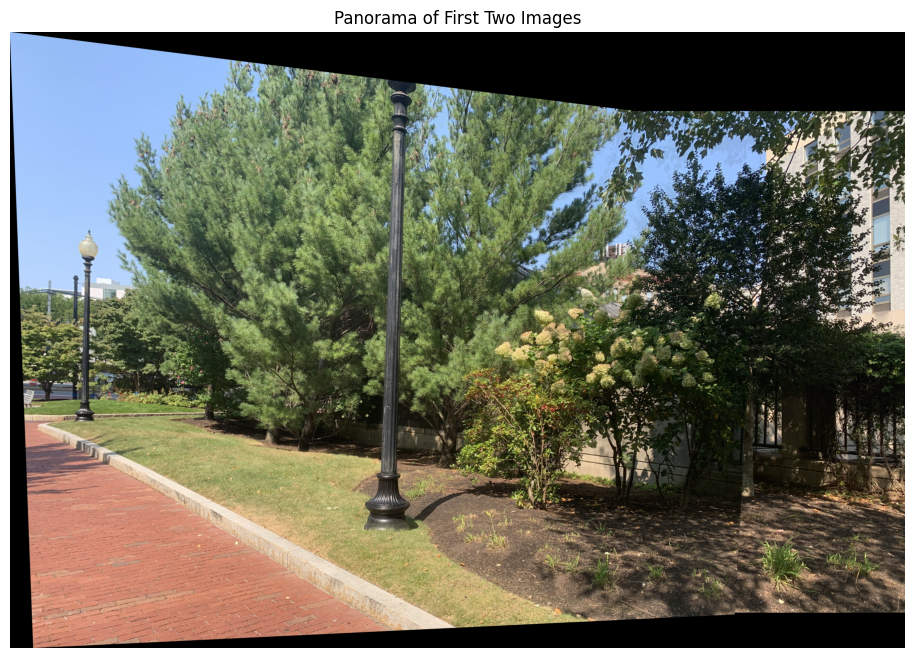

In [9]:
# Create panorama of the first 2 images
filename_01 = os.path.splitext(os.path.basename("Pan01.jpg"))[0]
filename_10 = os.path.splitext(os.path.basename("Pan10.jpg"))[0]

# We can uncomment the select_points() function in all the cases to use when we need to select the points for homography.
# Do this in Terminal or Command Prompt as GUI functions in matplotlib won't work well in Google Colab or Jupyter Notebook as described above.
# In all the cases, we will load points which I have already stored in CSV files.
# pts_left = select_points(im_left, "First Image (Leftmost image)", 8, f"{filename_01}.csv")
# pts_panorama_1 = select_points(im_mid_left, "Second Image (Mid-Left Image)", 8, f"{filename_10}.csv")

panorama_left_mid = create_panorama(im_left, filename_01, im_mid_left, filename_10, 0.9, 0.1)

# Display the panorama of first two images
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(panorama_left_mid, cv2.COLOR_BGR2RGB))
plt.title("Panorama of First Two Images")
plt.axis('off')
plt.show()

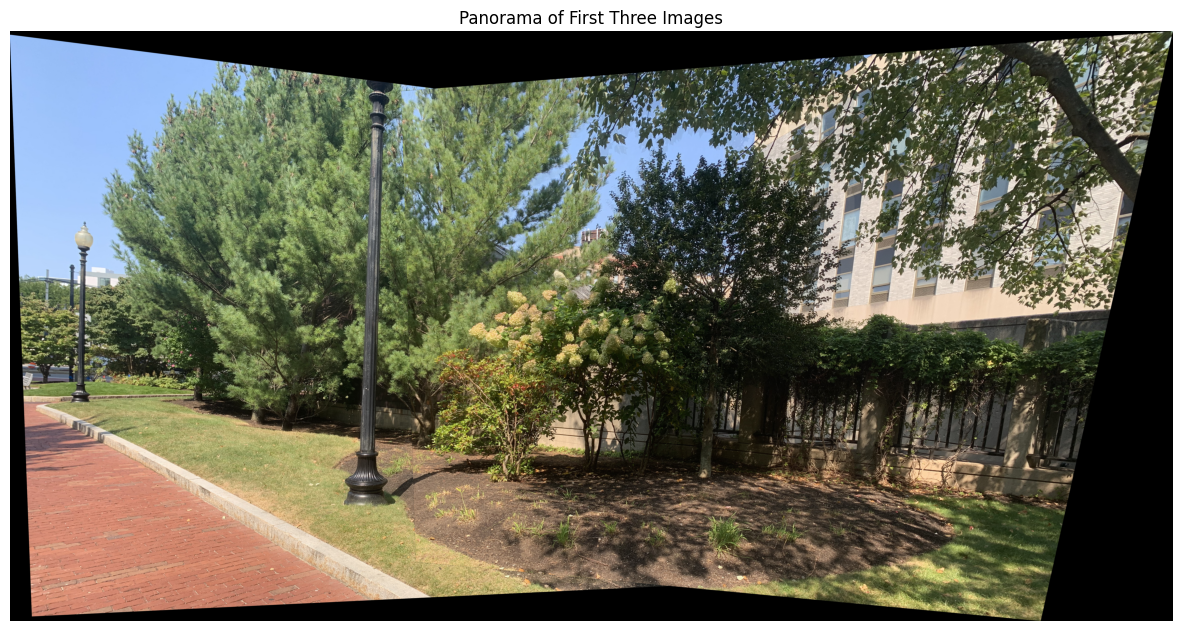

In [10]:
# Create panorama of the first 3 images
filename_210 = os.path.splitext(os.path.basename("Pan210.jpg"))[0]
filename_012 = os.path.splitext(os.path.basename("Pan012.jpg"))[0]

# pts_mid_right = select_points(im_mid_right, "Third Image (Centre Image)", 8, f"{filename_210}.csv")
# pts_panorama_2 = select_points(panorama_left_mid, "2-Image Panorama", 8, f"{filename_012}.csv")

panorama_three = create_panorama(im_mid_right, filename_210, panorama_left_mid, filename_012, 0.9, 0.1)

# Display the panorama of first three images
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(panorama_three, cv2.COLOR_BGR2RGB))
plt.title("Panorama of First Three Images")
plt.axis('off')
plt.show()

**As we can see from the output of this cell, the Panorama stitching works well with 3 images. Some edges are still visible, but in majority of the scene, the 3 images have blended well.**

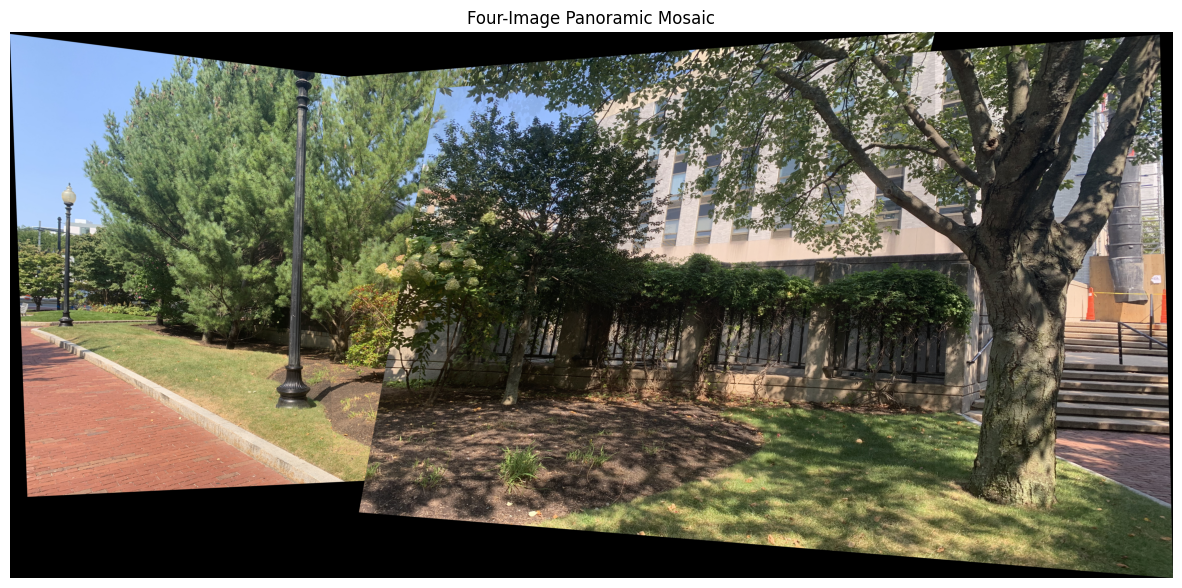

In [11]:
# Create panorama of the first 4 images
filename_3210 = os.path.splitext(os.path.basename("Pan3210.jpg"))[0]
filename_0123 = os.path.splitext(os.path.basename("Pan0123.jpg"))[0]

# pts_right = select_points(im_right, "Fourth Image (Mid-Right Image)", 8, f"{filename_3210}.csv")
# pts_panorama_3 = select_points(panorama_three, "3-Image Panorama", 8, f"{filename_0123}.csv")

# Create the final panorama with all four images
panorama_four = create_panorama( im_right, filename_3210, panorama_three, filename_0123, 0.9, 0.1)

# Display the panorama
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(panorama_four, cv2.COLOR_BGR2RGB))
plt.title("Four-Image Panoramic Mosaic")
plt.axis('off')
plt.show()

**From the 4th image onwards, we can see that there is a clear degradation in image stitching. This arises due to many factors which I will describe later. The main reason this is happening is because while taking the picture I have rotated the camera too much between the centre image, and the image right to it. The current algoorithm is insufficient too handle such cases.**

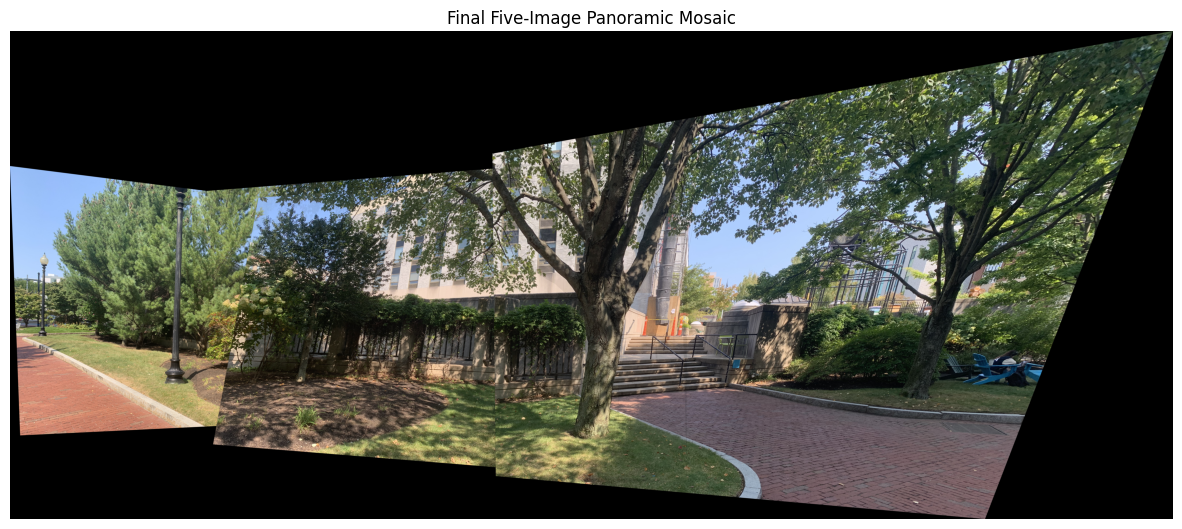

In [12]:
# Create panorama of all the 5 images
filename_43 = os.path.splitext(os.path.basename("Pan43.jpg"))[0]
filename_34 = os.path.splitext(os.path.basename("Pan34.jpg"))[0]

# pts_last = select_points(im_last, "Fifth Image (Rightmost Image)", 8, f"{filename_43}.csv")
# pts_panorama_4 = select_points(panorama_four, "4-Image Panorama", 8, f"{filename_34}.csv")

# Create the final panorama with all five images
final_panorama = create_panorama(im_last, filename_43, panorama_four, filename_34, 0.9, 0.1)

# Display the final panorama
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(final_panorama, cv2.COLOR_BGR2RGB))
plt.title("Final Five-Image Panoramic Mosaic")
plt.axis('off')
plt.show()

**This is the best mosaicking result I could get considering the conditions of my dataset. There is significant distortion in the stitching of the 5th image as it was completely out of the Field of view w.r.t. the centre image. I will now discuss what went wrong and how we could correct it.**

In [13]:
 cv2.imwrite('final_five_image_panorama_output.jpg', final_panorama)

True

## Observations from the final mosaic:

1. **Perspective Distortion:** The left-most,  mid-right, and the right-most images appear stretched due to perspective distortion caused by the planar homography transformation, especially for images at wider angles.
2. **Misalignment:** There seems to be a slight misalignment between the images, likely due to inaccurate homography estimation.
3. **Gaps and Overlap Issues:** Black areas indicate either gaps due to non-overlapping regions of the images.
4. **Number of Points for Homography and their selection**: I have selected 8 points for homography estimation in all the cases as 4 points homography wasn't working that well. I tried to distribute the points as much as possible so that they won't fall in a single line, and are not close to each other. However, warping issues still exist despite the careful selection.

## Corrections which can be made to get better panoramic stitching:

1. **Cylindrical Warping:** For wide panoramas, use cylindrical warping instead of planar homography to reduce perspective distortion and minimize stretching at the edges.
2. **RANSAC for Point Selection:** Using RANSAC can improve homography estimation by automatically identifying and excluding outlier points during point matching. It iteratively refines the homography, keeping only the inliers that provide the best transformation. This leads to more robust stitching and reduces misalignment and distortions in the panorama.
3. **Blend Function:** I have tried adjusting the alpha and beta blending values in overlapping regions to reduce visible seams. However, it is insufficent to provide a seamless transition between 2 images. We can explore methods like the **multiresolute spline** to resolve this.
4. **Apply Global Alignment:** We can use a stitching algorithm that applies bundle adjustment to optimize the alignment across all images.


**The linear blending technique combines two images using a fixed weighted average across the entire overlap, resulting in a smooth but uniform transition that can cause visible artifacts like blurred edges or double exposure, especially in areas with high detail. In contrast, the Multiresolution Spline technique works at multiple frequency levels, blending images differently at each resolution. This allows it to handle fine details and large features separately, creating a more seamless transition without blurring or degrading important image details.**